In [14]:
import numpy as np 
import pandas as pd
import shap

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


mpl.rcParams['figure.figsize'] = [20, 12]
mpl.rcParams['figure.dpi'] = 72

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
contemporary_era_baseball = pd.read_csv('../data/contemporary_era_pitchers_clusters.csv')
contemporary_era_baseball.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
contemporary_era_baseball.head()

,playerID,W,L,G,GS,CG,SV,SHO,IPouts,H,...,GIDP,Years_Played,HoF,votedBy,IP,ERA,TimeFrame,Name,FinalYear,cluster_label
0,kaatji01,283,237,898,625,180,18,31,13591,4620,...,NaN,25,1.0,NaN,4530.333333,3.452726,1959 - 1983,Jim Kaat,1983,1
1,normafr01,104,103,403,268,56,8,15,5819,1790,...,NaN,16,0.0,NaN,1939.666667,3.637738,1962 - 1980,Fred Norman,1980,-1
2,perryga01,314,265,777,690,303,11,53,16051,4938,...,NaN,22,1.0,BBWAA,5350.333333,3.105227,1962 - 1983,Gaylord Perry,1983,1
3,johnto01,288,231,760,700,162,4,46,14131,4783,...,NaN,26,0.0,NaN,4710.333333,3.341802,1963 - 1989,Tommy John,1989,1
4,niekrph01,318,274,864,716,245,29,45,16213,5044,...,NaN,24,1.0,BBWAA,5404.333333,3.350645,1964 - 1987,Phil Niekro,1987,1


<AxesSubplot:ylabel='HoF'>

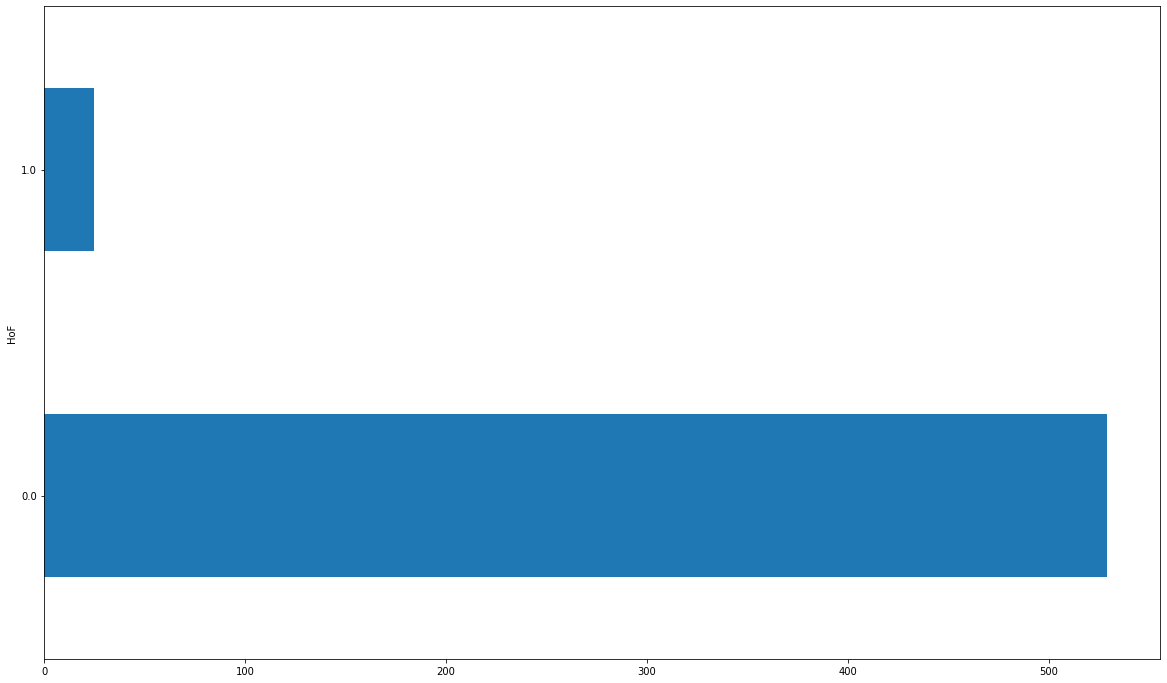

In [15]:
# what does our data distribution look like in regards to HoF vs Non-Hofs
contemporary_era_baseball.groupby('HoF')['playerID'].count().plot.barh()

In [7]:
# from our analysis we saw that Dennis Martinez belong to cluster #1
contemporary_era_baseball_clst_one = contemporary_era_baseball[contemporary_era_baseball.cluster_label == 1]

<AxesSubplot:ylabel='HoF'>

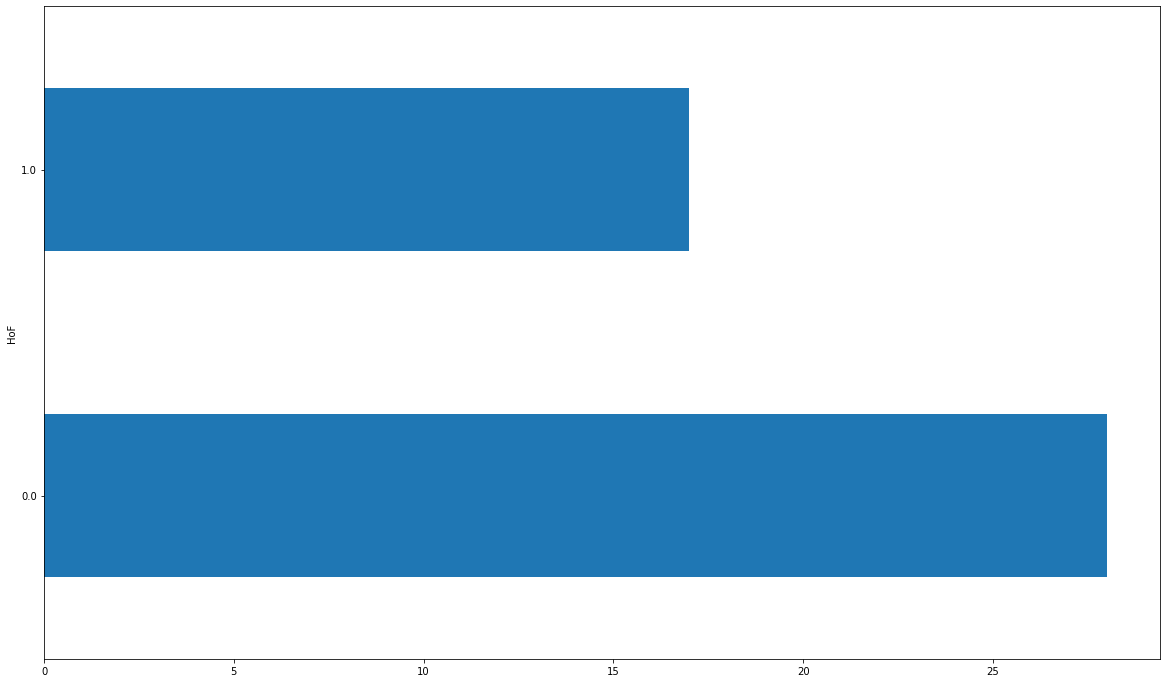

In [16]:
contemporary_era_baseball_clst_one.groupby('HoF')['playerID'].count().plot.barh()

In [17]:
#list of players eligible for 2023 veterans committee
players_elig_2023 = ['clemero02', 'schilcu01', 'brownke01', 'coneda01',
                     'saberbr01', 'stiebda01', 'appieke01', 'finlech01',
                     'hershor01', 'wellsda01', 'goodedw01', 'langsma01',
                     'keyji01', 'guidrro01', 'martide01', 'violafr01',
                     'leiteal01', 'rijojo01', 'candito01', 'darwida01'
                    ]

In [22]:
contemporary_era_baseball_clst_one[contemporary_era_baseball_clst_one.playerID.isin(players_elig_2023)].shape

(8, 34)

In [23]:
contemporary_era_baseball_clst_one[contemporary_era_baseball_clst_one.playerID.isin(players_elig_2023)]

,playerID,W,L,G,GS,CG,SV,SHO,IPouts,H,ER,HR,BB,SO,BAOpp,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,Years_Played,HoF,votedBy,IP,ERA,TimeFrame,Name,FinalYear,cluster_label
118,martide01,245,193,692,562,122,8,30,11999,3897,1643,372,1165,2149,0.245156,71.0,83,122.0,30,16754.0,51,1835,120.0,109.0,332.0,23,0.0,NaN,3999.666667,3.697058,1976 - 1998,Dennis Martinez,1998,1
138,darwida01,171,182,716,371,53,32,9,9050,2951,1286,321,874,1942,0.245896,101.0,52,81.0,17,12716.0,171,1431,124.0,111.0,194.0,21,0.0,NaN,3016.666667,3.836685,1978 - 1998,Danny Darwin,1998,1
212,hershor01,204,150,510,466,68,5,25,9391,2939,1211,235,1007,2014,0.238362,108.0,121,117.0,23,13150.0,19,1366,124.0,73.0,314.0,18,0.0,NaN,3130.333333,3.481738,1983 - 2000,Orel Hershiser,2000,1
221,clemero02,354,184,709,707,118,0,46,14750,4185,1707,363,1580,4672,0.221019,63.0,143,159.0,20,20240.0,0,1885,119.0,103.0,329.0,24,0.0,NaN,4916.666667,3.124678,1984 - 2007,Roger Clemens,2007,1
249,brownke01,211,144,486,476,72,0,17,9769,3079,1185,208,901,2397,0.239648,42.0,108,139.0,15,13542.0,1,1357,95.0,64.0,330.0,19,0.0,NaN,3256.333333,3.275156,1986 - 2005,Kevin Brown,2005,1
252,finlech01,200,173,524,467,63,0,15,9592,3069,1366,304,1332,2610,0.242398,36.0,130,76.0,22,13638.0,24,1517,104.0,85.0,305.0,17,0.0,NaN,3197.333333,3.845079,1986 - 2002,Chuck Finley,2002,1
274,wellsda01,239,157,660,489,54,13,12,10317,3635,1578,407,719,2201,0.260536,65.0,101,83.0,17,14413.0,65,1702,106.0,84.0,266.0,21,0.0,NaN,3439.000000,4.129689,1987 - 2007,David Wells,2007,1
287,schilcu01,216,146,569,436,83,22,20,9783,2998,1253,347,711,3116,0.234567,43.0,72,52.0,8,13284.0,81,1318,123.0,76.0,193.0,20,0.0,NaN,3261.000000,3.458142,1988 - 2007,Curt Schilling,2007,1


In [376]:
# I noticed that HR was read by the model as a good thing when in fact it should,
# I was curious as to whether it was taking Innings pitchched into consideration
contemporary_era_baseball_clst_one['HR_IP'] = contemporary_era_baseball_clst_one.HR/contemporary_era_baseball_clst_one.IP
contemporary_era_baseball_clst_one['SO_IP'] = contemporary_era_baseball_clst_one.SO/contemporary_era_baseball_clst_one.IP


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [403]:
# gathered from data_clustering notebook
valid_columns = ['W',
 'L',
 'G',
 'GS',
 'CG',
#  'SV',
 'SHO',
#  'IPouts',
 'H',
#  'ER',
#  'HR_IP',
 'BB',
 'SO',
 'BAOpp',
#  'IBB',
#  'WP',
 'HBP',
#  'BK',
#  'BFP',
#  'GF',
#  'R',
#  'SH',
#  'SF',
#  'GIDP',
 'Years_Played',
 'HoF',
 'IP',
 'ERA', 
 'playerID' # adding for filtering
]

In [404]:
# only 8 of those players eligible for 2023 were found in this cluster

In [405]:
X_values = contemporary_era_baseball_clst_one[valid_columns]
X_values['HoF'] = X_values['HoF'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [406]:
X_values.head()

,W,L,G,GS,CG,SHO,H,BB,SO,BAOpp,HBP,Years_Played,HoF,IP,ERA,playerID
0,283,237,898,625,180,31,4620,1083,2461,0.253693,122.0,25,1,4530.333333,3.452726,kaatji01
2,314,265,777,690,303,53,4938,1379,3534,0.235266,108.0,22,1,5350.333333,3.105227,perryga01
3,288,231,760,700,162,46,4783,1259,2245,0.252881,98.0,26,0,4710.333333,3.341802,johnto01
4,318,274,864,716,245,45,5044,1809,3342,0.237287,123.0,24,1,5404.333333,3.350645,niekrph01
5,229,172,573,484,187,49,3075,1104,2416,0.227206,49.0,19,0,3486.333333,3.304331,tiantlu01


In [407]:
candidates_stats_2023=X_values[
    X_values.playerID.isin(players_elig_2023)]

In [408]:
candidates_stats_2023

,W,L,G,GS,CG,SHO,H,BB,SO,BAOpp,HBP,Years_Played,HoF,IP,ERA,playerID
118,245,193,692,562,122,30,3897,1165,2149,0.245156,122.0,23,0,3999.666667,3.697058,martide01
138,171,182,716,371,53,9,2951,874,1942,0.245896,81.0,21,0,3016.666667,3.836685,darwida01
212,204,150,510,466,68,25,2939,1007,2014,0.238362,117.0,18,0,3130.333333,3.481738,hershor01
221,354,184,709,707,118,46,4185,1580,4672,0.221019,159.0,24,0,4916.666667,3.124678,clemero02
249,211,144,486,476,72,17,3079,901,2397,0.239648,139.0,19,0,3256.333333,3.275156,brownke01
252,200,173,524,467,63,15,3069,1332,2610,0.242398,76.0,17,0,3197.333333,3.845079,finlech01
274,239,157,660,489,54,12,3635,719,2201,0.260536,83.0,21,0,3439.000000,4.129689,wellsda01
287,216,146,569,436,83,20,2998,711,3116,0.234567,52.0,20,0,3261.000000,3.458142,schilcu01


In [409]:
non_candidates_2023 = X_values[
    ~X_values.playerID.isin(players_elig_2023)]

In [410]:
non_candidates_2023.head()

,W,L,G,GS,CG,SHO,H,BB,SO,BAOpp,HBP,Years_Played,HoF,IP,ERA,playerID
0,283,237,898,625,180,31,4620,1083,2461,0.253693,122.0,25,1,4530.333333,3.452726,kaatji01
2,314,265,777,690,303,53,4938,1379,3534,0.235266,108.0,22,1,5350.333333,3.105227,perryga01
3,288,231,760,700,162,46,4783,1259,2245,0.252881,98.0,26,0,4710.333333,3.341802,johnto01
4,318,274,864,716,245,45,5044,1809,3342,0.237287,123.0,24,1,5404.333333,3.350645,niekrph01
5,229,172,573,484,187,49,3075,1104,2416,0.227206,49.0,19,0,3486.333333,3.304331,tiantlu01


In [411]:
non_candidates_2023.groupby('HoF').count()['W']

HoF
0    20
1    17
Name: W, dtype: int64

In [412]:
X_train, X_val, y_train, y_val = train_test_split( 
    non_candidates_2023.drop(['HoF', 'playerID'], axis=1), 
    non_candidates_2023.HoF, 
    test_size=.20, 
    random_state=32)

In [445]:
def find_best_estimator(grid_search, X, y):
    grid_result = grid_search.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_estimator_, grid_search.best_params_


def output_confusion_matrices(clf, X_train, y_train, X_validation, y_validation):
    f, axes = plt.subplots(1, 2, figsize=(20, 10), sharey='row')

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_validation)

    cf_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
    cf_matrix_test = metrics.confusion_matrix(y_val, y_val_pred)

    disp_1 = metrics.ConfusionMatrixDisplay(cf_matrix_train, display_labels=clf.classes_)
    disp_2 = metrics.ConfusionMatrixDisplay(cf_matrix_test, display_labels=clf.classes_)
    displays = [disp_1, disp_2]

    matrices = {
        'Training Confuson Matrix': disp_1,
        'Validation Confusion Matrix': disp_2
    }

    for i, (key, disp) in enumerate(matrices.items()):
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.5, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    # f.colorbar(disp.im_, ax=axes)
    plt.show()
    
def display_shap_values(clf, X, graph_type='beeswarm', idx=None):
    explainer = shap.Explainer(clf.predict, X)
    shap_values = explainer(X)
    if graph_type == 'beeswarm':
        shap.plots.beeswarm(shap_values)
    elif graph_type == 'bar' and idx is not None:
        shap.plots.waterfall(shap_values[idx])
    else:
        print('Need to select beeswarm or specify index for bar graph')

In [414]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(random_state=42),
}

## Logistic Regression

In [361]:
model = LogisticRegression(max_iter=10000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)

log_clf, log_params = find_best_estimator(grid_search, X_train, y_train)


Best: 0.856151 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795139 (0.147658) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.686508 (0.101127) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696429 (0.110253) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.791171 (0.117706) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.708829 (0.110993) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696429 (0.110253) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.813492 (0.071875) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.705357 (0.117600) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.699901 (0.103476) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.839782 (0.051130) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.819444 (0.070044) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696429 (0.110253) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.856151 (0.050293) wi

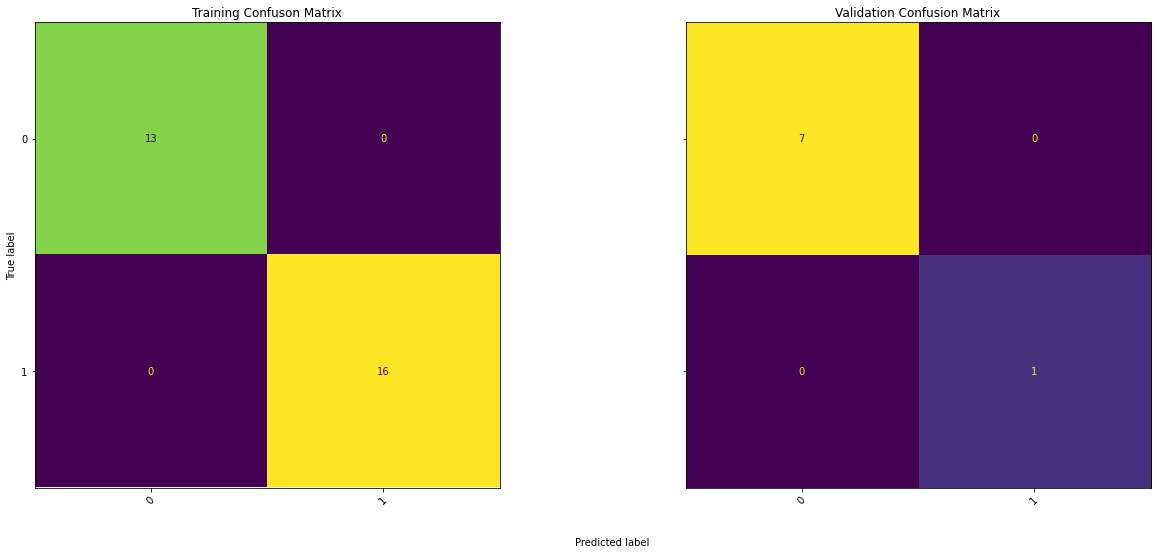

In [362]:
output_confusion_matrices(log_clf, X_train, y_train, X_val, y_val)

In [370]:
model = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cv, scoring='roc_auc')

rf_clf, rf_params = find_best_estimator(grid_search, X_train, y_train)

Best: 0.876488 using {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.872520 (0.069467) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.876488 (0.073179) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.872520 (0.069467) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.876488 (0.073179) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.872520 (0.069467) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
0.876488 (0.073179) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
0.872520 (0.069467) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
0.876488 (0.073179) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
0.872520 (0.069467) with

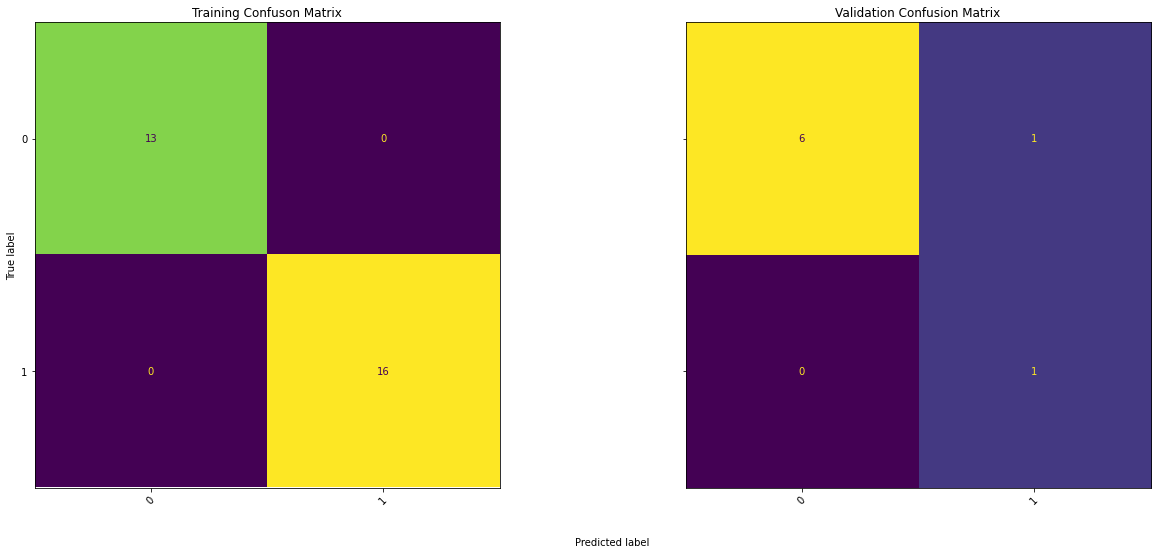

In [371]:
output_confusion_matrices(rf_clf, X_train, y_train, X_val, y_val)

In [415]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05, .001],
    'scale_pos_weight': [0,5,10,15,20, 50, 100]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = cv,
    verbose=True
)

xgb_clf, xgb_params = find_best_estimator(grid_search, X_train, y_train)

Fitting 6 folds for each of 896 candidates, totalling 5376 fits
Best: 0.886905 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 5}
0.500000 (0.000000) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 0}
0.877976 (0.042098) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 5}
0.856895 (0.037709) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 10}
0.852927 (0.031875) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 15}
0.850942 (0.042181) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 20}
0.849950 (0.041599) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 50}
0.867312 (0.051581) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 100}
0.500000 (0.000000) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_es

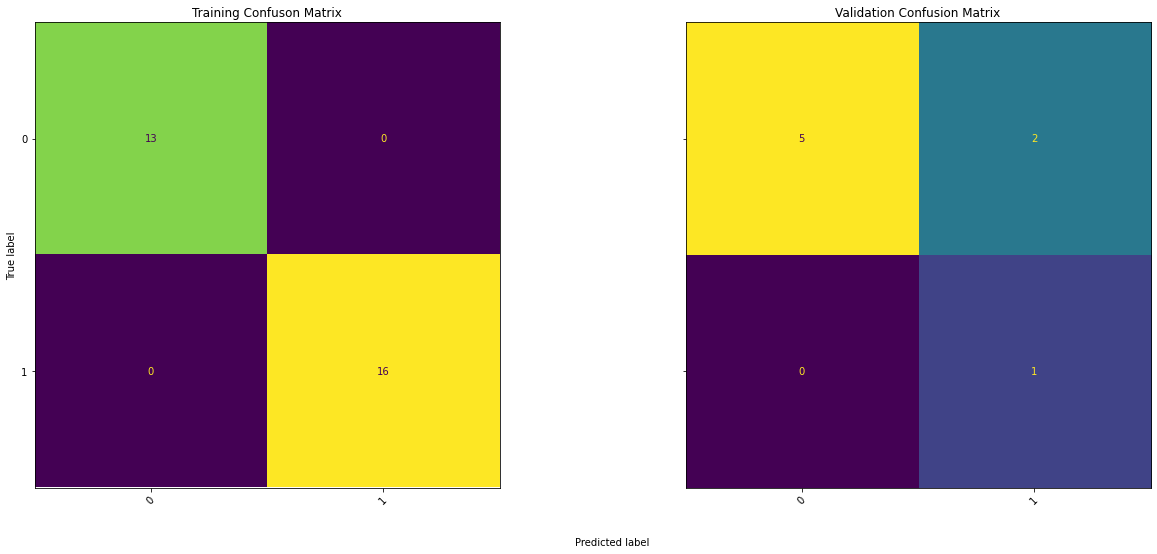

In [416]:
output_confusion_matrices(xgb_clf, X_train, y_train, X_val, y_val)

In [422]:
candidates_stats_2023

,W,L,G,GS,CG,SHO,H,BB,SO,BAOpp,HBP,Years_Played,HoF,IP,ERA,playerID
118,245,193,692,562,122,30,3897,1165,2149,0.245156,122.0,23,0,3999.666667,3.697058,martide01
138,171,182,716,371,53,9,2951,874,1942,0.245896,81.0,21,0,3016.666667,3.836685,darwida01
212,204,150,510,466,68,25,2939,1007,2014,0.238362,117.0,18,0,3130.333333,3.481738,hershor01
221,354,184,709,707,118,46,4185,1580,4672,0.221019,159.0,24,0,4916.666667,3.124678,clemero02
249,211,144,486,476,72,17,3079,901,2397,0.239648,139.0,19,0,3256.333333,3.275156,brownke01
252,200,173,524,467,63,15,3069,1332,2610,0.242398,76.0,17,0,3197.333333,3.845079,finlech01
274,239,157,660,489,54,12,3635,719,2201,0.260536,83.0,21,0,3439.000000,4.129689,wellsda01
287,216,146,569,436,83,20,2998,711,3116,0.234567,52.0,20,0,3261.000000,3.458142,schilcu01


In [423]:
xgb_clf.predict_proba(candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

array([[0.90080446, 0.09919555],
       [0.9505065 , 0.04949347],
       [0.759833  , 0.24016704],
       [0.0076161 , 0.9923839 ],
       [0.5634395 , 0.4365605 ],
       [0.6424568 , 0.35754317],
       [0.5026566 , 0.49734342],
       [0.07568395, 0.92431605]], dtype=float32)

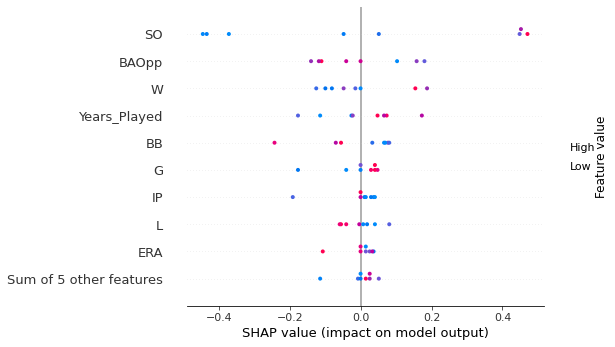

In [424]:
display_shap_values(xgb_clf, candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

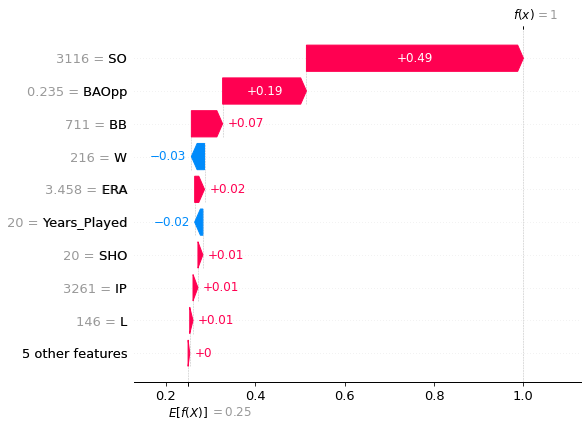

In [428]:
#roc_auc
display_shap_values(xgb_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='schilcu01')[0][0])

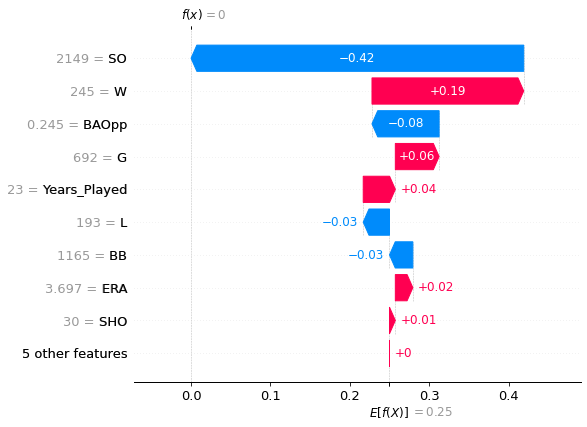

In [429]:
display_shap_values(xgb_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='martide01')[0][0])

In [372]:
rf_clf.predict(candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

array([0, 0, 0, 1, 0, 0, 0, 1])

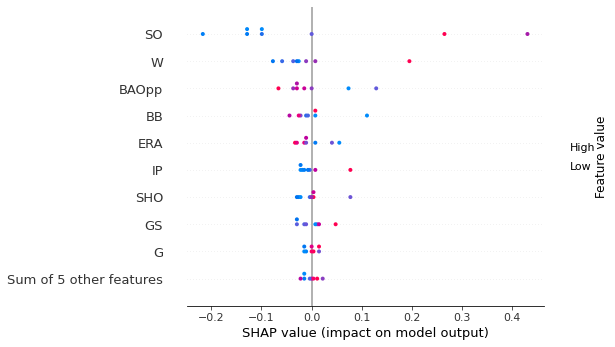

In [373]:
display_shap_values(rf_clf, candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

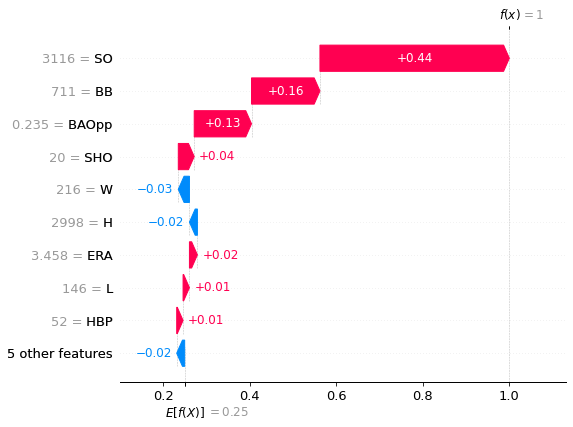

In [374]:
#roc_auc
display_shap_values(rf_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='schilcu01')[0][0])

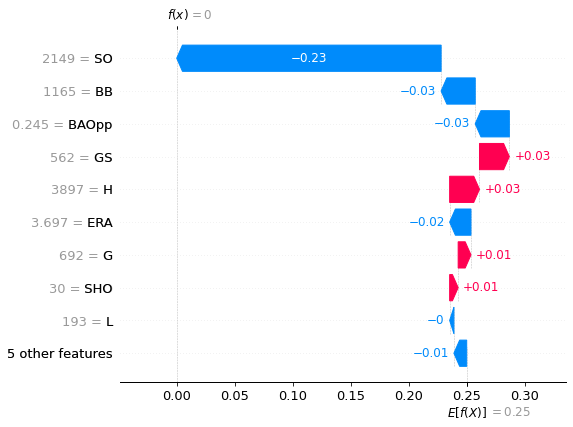

/Users/ricky/.pyenv/versions/3.8.6/envs/baseball_env/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ricky/.pyenv/versions/3.8.6/envs/baseball_env/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [375]:
#roc_auc
display_shap_values(rf_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='martide01')[0][0])

In [369]:
log_clf.predict(candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

array([0, 0, 0, 1, 0, 0, 0, 1])

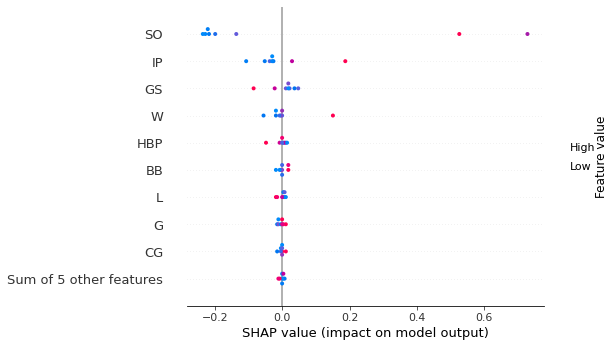

In [364]:
display_shap_values(log_clf, candidates_stats_2023.drop(['playerID', 'HoF'], axis=1))

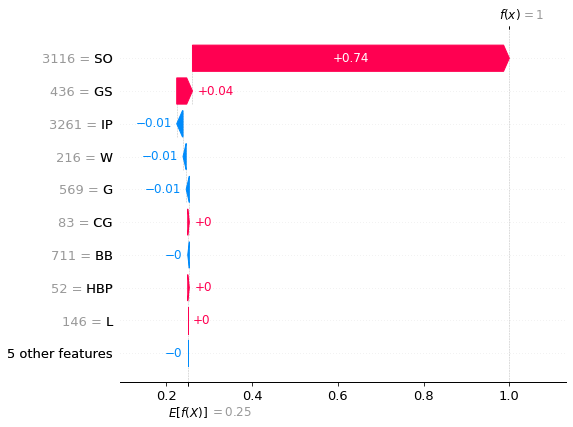

In [365]:
#roc_auc
display_shap_values(log_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='schilcu01')[0][0])

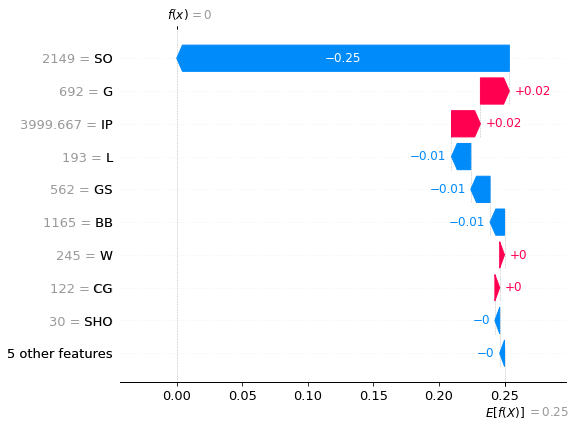

In [366]:
#roc_auc
display_shap_values(log_clf, 
                    candidates_stats_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_2023.playerID=='martide01')[0][0])

# Model Preds with Advanced Stats

In [432]:
contemporary_era_baseball_adv = pd.read_csv('../data/contemporary_era_pitchers_clusters_adv.csv')
contemporary_era_baseball_adv.drop('Unnamed: 0', axis=1, inplace=True)

In [515]:
contemporary_era_baseball_adv[contemporary_era_baseball_adv.playerID=='martide01']

,playerID,ERA+,WHIP,H9,HR9,BB9,SO9,SO_W,BIP,BIP_perc,ERA_plus,ER_lg,GR_leverage_index_avg,IPouts_relief,IPouts_start,PPF,PPF_custom,RA,RS_def_total,RpO_replacement,WAA,WAA_adj,WAR,WAR_rep,oppRpG,oppRpG_rep,pyth_exponent,pyth_exponent_rep,runs_above_avg,runs_above_avg_adj,runs_above_rep,teamRpG,waa_win_perc,waa_win_perc_rep,xRA,xRA_def_pitcher,xRA_final,xRA_sprp_adj,W,L,G,GS,CG,SV,SHO,IPouts,H,ER,HR,BB,SO,BAOpp,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,Years_Played,HoF,votedBy,IP,ERA,TimeFrame,Name,FinalYear,cluster_label
118,martide01,105.791667,1.328875,9.233333,0.833333,2.741667,4.75,1.844635,548.208333,0.124088,106.393449,72.724083,1.207029,34.083333,465.875,98.083333,98.571708,76.458333,11.608333,0.197208,14.6503,-2.609,49.26,1.5515,4.30935,5.003256,1.853417,1.895917,126.584,4.720167,495.755,4.463146,0.521733,0.446242,82.45825,1.575042,81.732667,2.088083,245,193,692,562,122,8,30,11999,3897,1643,372,1165,2149,0.245156,71.0,83,122.0,30,16754.0,51,1835,120.0,109.0,332.0,23,0.0,NaN,3999.666667,3.697058,1976 - 1998,Dennis Martinez,1998,3


In [433]:
contemporary_era_baseball_adv.head()

,playerID,ERA+,WHIP,H9,HR9,BB9,SO9,SO_W,BIP,BIP_perc,ERA_plus,ER_lg,GR_leverage_index_avg,IPouts_relief,IPouts_start,PPF,PPF_custom,RA,RS_def_total,RpO_replacement,WAA,WAA_adj,WAR,WAR_rep,oppRpG,oppRpG_rep,pyth_exponent,pyth_exponent_rep,runs_above_avg,runs_above_avg_adj,runs_above_rep,teamRpG,waa_win_perc,waa_win_perc_rep,xRA,xRA_def_pitcher,xRA_final,xRA_sprp_adj,W,L,G,GS,CG,SV,SHO,IPouts,H,ER,HR,BB,SO,BAOpp,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,Years_Played,HoF,votedBy,IP,ERA,TimeFrame,Name,FinalYear,cluster_label
0,kaatji01,101.035714,1.378143,9.675000,0.821429,2.721429,4.342857,2.272392,538.714286,0.118229,101.729012,66.770929,1.400211,40.214286,445.142857,102.285714,101.974679,72.785714,12.864286,0.180643,7.7534,-3.5333,45.21,1.464164,4.188893,4.513088,1.825429,1.847214,30.011,1.765500,400.947,4.113336,0.496089,0.457214,72.776893,1.739464,73.857536,0.951179,283,237,898,625,180,18,31,13591,4620,1738,395,1083,2461,0.253693,116.0,128,122.0,6,19023.0,102,2038,NaN,NaN,NaN,25,1.0,NaN,4530.333333,3.452726,1959 - 1983,Jim Kaat,1983,3
1,normafr01,91.941176,1.601765,9.417647,0.988235,5.000000,6.705882,1.598773,351.117647,0.075182,94.072578,45.280412,1.255865,36.764706,305.176471,99.411765,100.125412,50.823529,-6.511765,0.180471,0.7159,-0.9409,17.13,1.020888,4.310686,4.469745,1.834059,1.845000,15.887,0.073824,173.993,4.112249,0.483565,0.461776,52.294941,0.096471,51.758059,0.943471,104,103,403,268,56,8,15,5819,1790,784,188,815,1303,0.235248,79.0,89,23.0,12,8279.0,42,864,NaN,NaN,NaN,16,0.0,NaN,1939.666667,3.637738,1962 - 1980,Fred Norman,1980,7
2,perryga01,113.240000,1.242960,8.788000,0.704000,2.388000,5.756000,2.562727,665.640000,0.144884,113.532756,86.568080,1.455308,22.360000,619.640000,99.760000,99.843200,85.120000,-8.816000,0.183880,44.9060,-2.6161,93.03,2.030208,3.791620,4.744515,1.801920,1.862920,394.237,14.547920,863.206,4.147668,0.544916,0.437812,97.909400,-1.095320,100.889480,2.018160,314,265,777,690,303,11,53,16051,4938,1846,399,1379,3534,0.235266,164.0,160,108.0,6,21953.0,33,2128,NaN,NaN,NaN,22,1.0,BBWAA,5350.333333,3.105227,1962 - 1983,Gaylord Perry,1983,3
3,johnto01,112.285714,1.327821,9.525000,0.625000,2.435714,4.160714,1.783161,567.642857,0.123400,112.825355,69.082500,1.045032,12.107143,492.535714,98.107143,97.918429,72.035714,7.685714,0.185750,21.6428,-2.4910,62.08,1.533464,4.069774,4.738421,1.825071,1.867000,173.508,6.391464,577.543,4.223742,0.520571,0.446621,78.507000,0.637643,78.232429,1.868143,288,231,760,700,162,4,46,14131,4783,1749,302,1259,2245,0.252881,102.0,187,98.0,16,19692.0,22,2017,NaN,NaN,NaN,26,0.0,NaN,4710.333333,3.341802,1963 - 1989,Tommy John,1989,3
4,niekrph01,109.692308,1.418923,8.965385,0.850000,3.807692,5.150000,1.847430,655.538462,0.141000,110.060381,89.171385,1.621662,30.153846,593.384615,103.807692,103.414346,89.884615,-22.976923,0.184500,50.4554,-2.6080,96.96,1.888442,3.978347,4.685977,1.814615,1.861500,454.514,15.962962,909.984,4.183705,0.532073,0.447569,96.479731,-4.203500,107.365923,2.296846,318,274,864,716,245,29,45,16213,5044,2012,482,1809,3342,0.237287,86.0,226,123.0,42,22677.0,83,2337,NaN,NaN,NaN,24,1.0,BBWAA,5404.333333,3.350645,1964 - 1987,Phil Niekro,1987,3


In [435]:
contemporary_era_baseball_adv_clst_3 = contemporary_era_baseball_adv[contemporary_era_baseball_adv.cluster_label == 3]

In [436]:
contemporary_era_baseball_adv_clst_3[contemporary_era_baseball_adv_clst_3.playerID.isin(players_elig_2023)].shape

(8, 71)

<AxesSubplot:ylabel='HoF'>

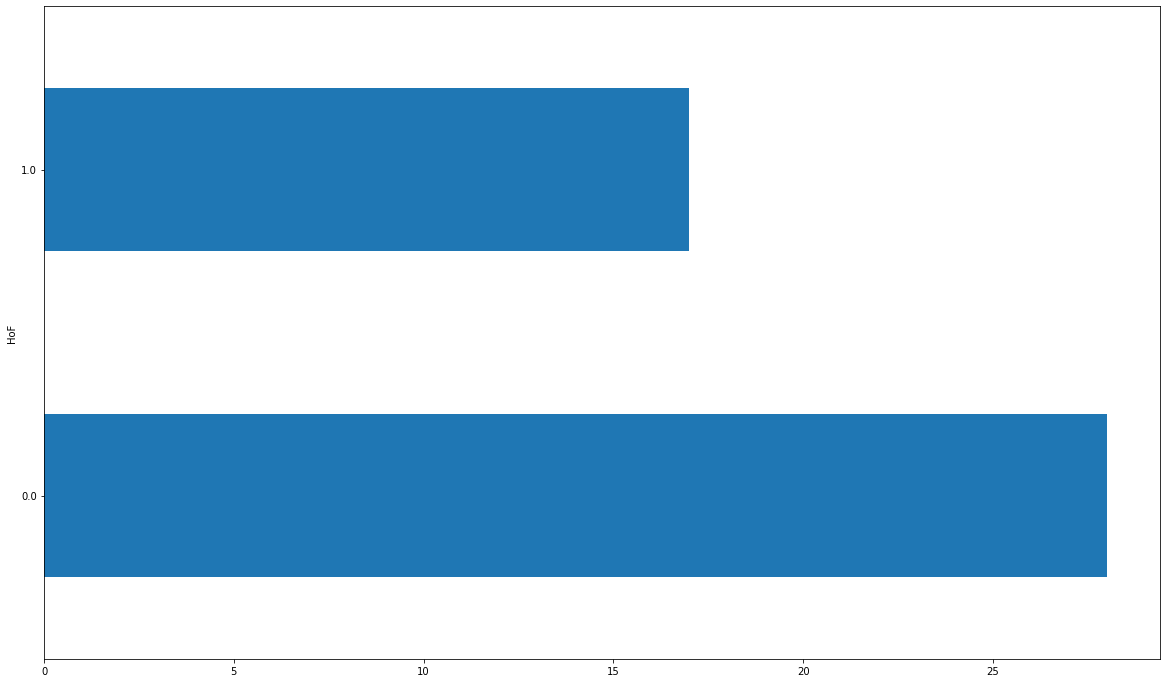

In [437]:
contemporary_era_baseball_adv_clst_3.groupby('HoF')['playerID'].count().plot.barh()

In [501]:
valid_columns_2 = [    
    'playerID',
 'WHIP',
 'H9',
 'HR9',
 'BB9',
 'SO9',
#  'SO_W',
#  'BIP',
#  'BIP_perc',
 'ERA_plus',
#  'ER_lg',
#  'GR_leverage_index_avg',
#  'IPouts_relief',
#  'IPouts_start',
#  'PPF',
#  'PPF_custom',
 'RA',
#  'RS_def_total',
#  'RpO_replacement',
 'WAA',
#  'WAA_adj',
 'WAR',
#  'WAR_rep',
#  'oppRpG',
#  'oppRpG_rep',
#  'pyth_exponent',
#  'pyth_exponent_rep',
 'runs_above_avg',
#  'runs_above_avg_adj',
#  'runs_above_rep',
#  'teamRpG',
 'waa_win_perc',
#  'waa_win_perc_rep',
 'xRA',
#  'xRA_def_pitcher',
#  'xRA_final',
#  'xRA_sprp_adj',
 'W',
 'L',
 'G',
 'GS',
 'CG',
#  'SV',
 'SHO',
#  'IPouts',
#  'H',
 'ER',
#  'HR',
#  'BB',
#  'SO',
 'BAOpp',
#  'IBB',
#  'WP',
#  'HBP',
#  'BK',
#  'BFP',
 'GF',
#  'R',
 'Years_Played',
 'HoF',
 'IP',
 'ERA']

In [502]:
X_values_adv = contemporary_era_baseball_adv_clst_3[valid_columns_2]
X_values_adv['HoF'] = X_values_adv['HoF'].astype(int)

candidates_stats_adv_2023=X_values_adv[
    X_values_adv.playerID.isin(players_elig_2023)]

non_candidates_adv_2023 = X_values_adv[
    ~X_values_adv.playerID.isin(players_elig_2023)]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [503]:
X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split( 
    non_candidates_adv_2023.drop(['HoF', 'playerID'], axis=1), 
    non_candidates_adv_2023.HoF, 
    test_size=.20, 
    random_state=32)

In [504]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05, .001],
    'scale_pos_weight': [0,5,10,15,20, 50, 100]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = cv,
    verbose=True
)

xgb_clf_adv, xgb_params_adv = find_best_estimator(grid_search, X_train_adv, y_train_adv)

Fitting 6 folds for each of 896 candidates, totalling 5376 fits
Best: 0.862847 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 50}
0.500000 (0.000000) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 0}
0.845486 (0.038426) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 5}
0.832341 (0.068526) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 10}
0.827133 (0.055029) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 15}
0.832341 (0.049014) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 20}
0.846726 (0.070576) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 50}
0.846726 (0.079721) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'scale_pos_weight': 100}
0.500000 (0.000000) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_e

In [505]:
# non_candidates_adv_2023[non_candidates_adv_2023.playerID == 'morrija02']

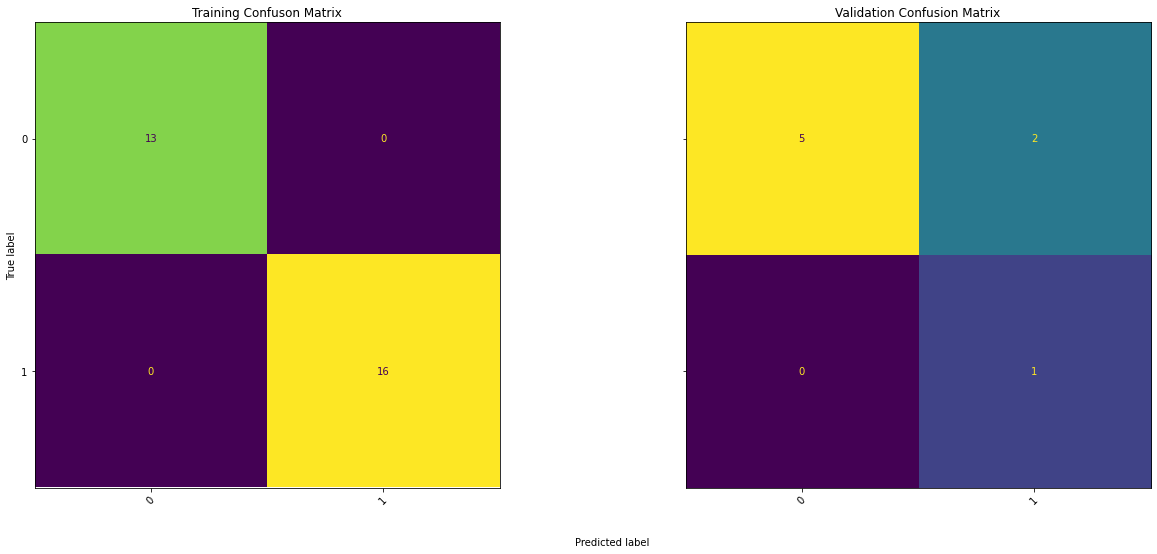

In [506]:
output_confusion_matrices(xgb_clf_adv, X_train_adv, y_train_adv, X_val_adv, y_val_adv)

In [507]:
candidates_stats_adv_2023

,playerID,WHIP,H9,HR9,BB9,SO9,ERA_plus,RA,WAA,WAR,runs_above_avg,waa_win_perc,xRA,W,L,G,GS,CG,SHO,ER,BAOpp,GF,Years_Played,HoF,IP,ERA
118,martide01,1.328875,9.233333,0.833333,2.741667,4.750000,106.393449,76.458333,14.6503,49.26,126.584,0.521733,82.458250,245,193,692,562,122,30,1643,0.245156,51,23,0,3999.666667,3.697058
138,darwida01,1.296920,9.116000,1.028000,2.560000,5.992000,107.587499,57.240000,13.0241,40.28,109.763,0.504304,60.701120,171,182,716,371,53,9,1286,0.245896,171,21,0,3016.666667,3.836685
212,hershor01,1.336222,8.872222,0.744444,3.150000,5.688889,110.686530,75.888889,24.7568,51.35,225.998,0.530322,85.058056,204,150,510,466,68,25,1211,0.238362,19,18,0,3130.333333,3.481738
221,clemero02,1.188292,7.766667,0.687500,2.933333,8.437500,148.001418,78.541667,93.8879,138.67,859.374,0.626529,108.853792,354,184,709,707,118,46,1707,0.221019,0,24,0,4916.666667,3.124678
249,brownke01,1.278737,9.057895,0.605263,2.452632,6.552632,127.563699,71.421053,40.1940,68.21,367.764,0.565447,89.805211,211,144,486,476,72,17,1185,0.239648,1,19,0,3256.333333,3.275156
252,finlech01,1.383000,8.666667,0.822222,3.783333,7.377778,115.207727,84.277778,28.4071,58.32,268.598,0.548944,95.900778,200,173,524,467,63,15,1366,0.242398,24,17,0,3197.333333,3.845079
274,wellsda01,1.305333,9.704167,1.037500,2.045833,5.833333,109.781868,70.916667,22.0316,53.61,218.312,0.534604,77.471917,239,157,660,489,54,12,1578,0.260536,65,21,0,3439.000000,4.129689
287,schilcu01,1.239095,8.766667,1.019048,2.380952,7.895238,120.627114,62.761905,53.8906,80.51,499.999,0.580662,81.365238,216,146,569,436,83,20,1253,0.234567,81,20,0,3261.000000,3.458142


In [508]:
xgb_clf_adv.predict(candidates_stats_adv_2023.drop(['playerID', 'HoF'], axis=1))

array([1, 0, 0, 1, 1, 0, 0, 1])

In [509]:
xgb_clf_adv.predict_proba(candidates_stats_adv_2023.drop(['playerID', 'HoF'], axis=1))

array([[4.71927166e-01, 5.28072834e-01],
       [9.97654378e-01, 2.34560482e-03],
       [9.44073856e-01, 5.59261702e-02],
       [5.73277473e-04, 9.99426723e-01],
       [6.72661662e-02, 9.32733834e-01],
       [5.84126413e-01, 4.15873587e-01],
       [9.84402061e-01, 1.55979395e-02],
       [1.40293241e-02, 9.85970676e-01]], dtype=float32)

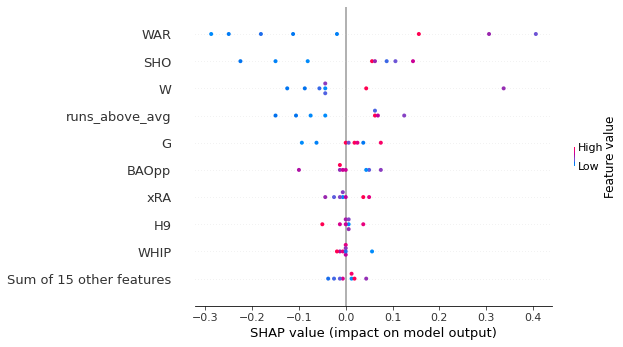

In [510]:
#roc_auc
display_shap_values(xgb_clf_adv, candidates_stats_adv_2023.drop(['playerID', 'HoF'], axis=1))

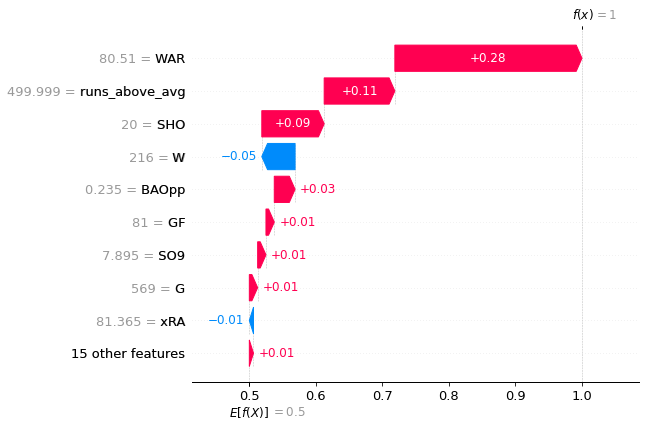

In [511]:
display_shap_values(xgb_clf_adv, 
                    candidates_stats_adv_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_adv_2023.playerID=='schilcu01')[0][0])

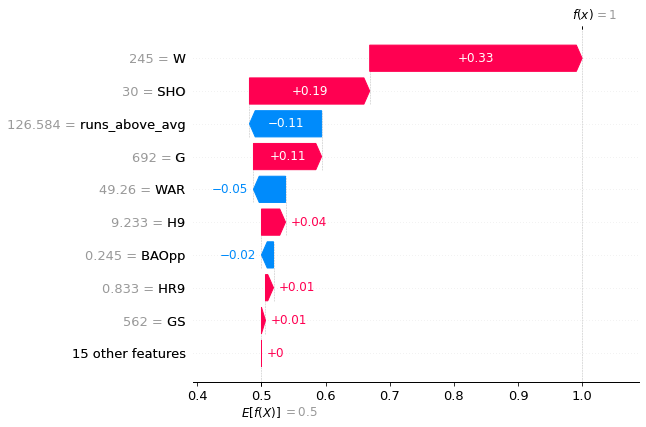

In [512]:
display_shap_values(xgb_clf_adv, 
                    candidates_stats_adv_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(candidates_stats_adv_2023.playerID=='martide01')[0][0])

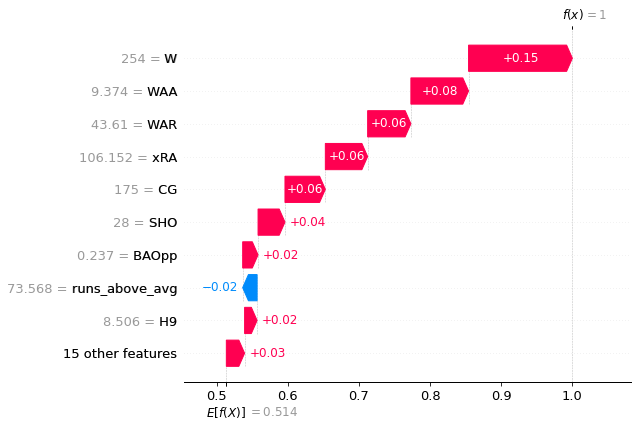

In [513]:
display_shap_values(xgb_clf_adv, 
                    non_candidates_adv_2023.drop(['playerID', 'HoF'], axis=1), 
                    graph_type='bar',
                    idx=np.where(non_candidates_adv_2023.playerID=='morrija02')[0][0])

In [514]:
candidates_stats_adv_2023[candidates_stats_adv_2023.playerID=='martide01']

,playerID,WHIP,H9,HR9,BB9,SO9,ERA_plus,RA,WAA,WAR,runs_above_avg,waa_win_perc,xRA,W,L,G,GS,CG,SHO,ER,BAOpp,GF,Years_Played,HoF,IP,ERA
118,martide01,1.328875,9.233333,0.833333,2.741667,4.75,106.393449,76.458333,14.6503,49.26,126.584,0.521733,82.45825,245,193,692,562,122,30,1643,0.245156,51,23,0,3999.666667,3.697058
